<a href="https://colab.research.google.com/github/qsamson/BiCauchy-ROC-curves/blob/main/Copy_of_Untitled15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import os

# This will prompt you to upload a file
uploaded = files.upload()

# Get the name of the uploaded zip file
zip_file_name = list(uploaded.keys())[0]

# Unzip the file into a new folder
os.system(f"unzip -q {zip_file_name}")

print(f"\nSuccessfully uploaded and unzipped your files.")

Saving NOLA_Crime_Data.zip to NOLA_Crime_Data.zip

Successfully uploaded and unzipped your files.


In [ ]:
import pandas as pd
import os

# --- Configuration ---
# The path is now set to the folder created by unzipping.
# Do not change this path.
data_folder_path = 'NOLA_Crime_Data'

output_file_name = 'NOLA_Calls_for_Service_Combined.csv'
# -------------------

print(f"Searching for files in: {data_folder_path}")
all_files = [f for f in os.listdir(data_folder_path) if f.endswith('.csv')]

if not all_files:
    print("\nError: No CSV files were found in the unzipped folder.")
else:
    list_of_dataframes = []
    print("\nReading files...")
    for file in all_files:
        file_path = os.path.join(data_folder_path, file)
        try:
            # This handles any corrupted rows in the data
            df = pd.read_csv(file_path, on_bad_lines='warn', low_memory=False)
            list_of_dataframes.append(df)
            print(f" - Added {file}")
        except Exception as e:
            print(f" - Could not read {file}. Error: {e}")

    if list_of_dataframes:
        print("\nCombining datasets...")
        combined_df = pd.concat(list_of_dataframes, ignore_index=True)
        combined_df.to_csv(output_file_name, index=False)
        print(f"\nSuccess! Combined data saved to: {output_file_name}")
        print(f"You can now download this file from the file pane on the left.")
    else:
        print("\nCould not combine files. No data was read.")

Searching for files in: NOLA_Crime_Data

Reading files...
 - Added Calls_for_Service_2024.csv
 - Added Calls_for_Service_2020.csv
 - Added Calls_for_Service_2021.csv
 - Added Calls_for_Service_2025.csv
 - Added Calls_for_Service_2022.csv
 - Added Calls_for_Service_2023.csv

Combining datasets...

Success! Combined data saved to: NOLA_Calls_for_Service_Combined.csv
You can now download this file from the file pane on the left.


In [ ]:
import pandas as pd

# --- Configuration ---
# The name of the combined file you created and uploaded
file_name = 'NOLA_Calls_for_Service_Combined.csv'
# -------------------

print(f"Loading the combined dataset: {file_name}...")
# Load the data. This might take a moment.
df = pd.read_csv(file_name, low_memory=False)
print("Dataset loaded successfully.")

# --- Data Cleaning and Preparation ---

# 1. Standardize Column Names (optional but good practice)
#    - Makes column names lowercase and removes spaces for easier access.
df.columns = df.columns.str.lower().str.replace(' ', '_')

# 2. Convert Time/Date Column
#    - The 'timecreate' column needs to be converted from text to a proper datetime format.
print("\nConverting date and time information...")
# This tells pandas to interpret the 'timecreate' column as dates, ignoring any errors.
df['timecreate'] = pd.to_datetime(df['timecreate'], errors='coerce')

# 3. Filter to Your 5-Year Window
#    - Keep only the data from September 2020 to September 2025.
print("Filtering data to the five-year window (Sep 2020 - Sep 2025)...")
start_date = '2020-09-01'
end_date = '2025-09-30'
# This creates a boolean mask and applies it to the dataframe.
df_filtered = df[(df['timecreate'] >= start_date) & (df['timecreate'] <= end_date)].copy()

# 4. Prepare Location Data for Mapping
#    - The mapping software needs clean latitude and longitude data.
#    - We will drop any rows where the location is missing, as they cannot be mapped.
print("Cleaning location data...")
# Count missing locations before cleaning
original_rows = len(df_filtered)
df_filtered.dropna(subset=['location'], inplace=True)
cleaned_rows = len(df_filtered)
rows_dropped = original_rows - cleaned_rows
print(f" - Dropped {rows_dropped} rows with no location data.")


# --- Final Output ---
print("\n--- Data Preparation Complete ---")
print(f"Your final, cleaned dataset has {len(df_filtered)} records.")
print("The data is now ready for hotspot analysis and mapping.")

# Display the first 5 rows of your cleaned data to see the result
print("\nSample of cleaned data:")
print(df_filtered.head())

# Save the cleaned file for the next step (optional but recommended)
cleaned_file_name = 'NOLA_Calls_for_Service_Cleaned.csv'
df_filtered.to_csv(cleaned_file_name, index=False)
print(f"\nCleaned data saved to '{cleaned_file_name}'. You can use this for the mapping step.")

Loading the combined dataset: NOLA_Calls_for_Service_Combined.csv...
Dataset loaded successfully.

Converting date and time information...


/tmp/ipython-input-3822114792.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timecreate'] = pd.to_datetime(df['timecreate'], errors='coerce')


Filtering data to the five-year window (Sep 2020 - Sep 2025)...
Cleaning location data...
 - Dropped 0 rows with no location data.

--- Data Preparation Complete ---
Your final, cleaned dataset has 1812356 records.
The data is now ready for hotspot analysis and mapping.

Sample of cleaned data:
  nopd_item type         typetext priority initialtype  initialtypetext  \
0  J2775724   24          MEDICAL       2D          24          MEDICAL   
1  I0437624   43      SIMPLE RAPE       2F          42  AGGRAVATED RAPE   
2  J1875124  22A       AREA CHECK       1K         22A       AREA CHECK   
3  L0533524   24          MEDICAL       2D          21  COMPLAINT OTHER   
4  J1047624   21  COMPLAINT OTHER       1F          21  COMPLAINT OTHER   

  initialpriority      mapx     mapy          timecreate  ...  \
0              2D  37369000  3513814 2024-10-28 00:06:24  ...   
1              2C  37369000  3513814 2024-09-05 08:11:09  ...   
2              1K         0        0 2024-10-19 08:24:14  

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import re # Using the regular expression library for robust parsing

# --- Configuration ---
cleaned_file_name = 'NOLA_Calls_for_Service_Cleaned.csv'
output_map_file = 'NOLA_Crime_Heatmap.html'
# -------------------

print(f"Loading cleaned data from '{cleaned_file_name}'...")
df = pd.read_csv(cleaned_file_name)

# --- 1. Extract Latitude and Longitude ---
# The 'location' column is a string like 'POINT (-90.08123 29.94106)'.
# We need to extract the two numbers (longitude and latitude) from it.

print("Extracting latitude and longitude from the 'location' column...")

# This function will parse the string and return lat and lon
def extract_lat_lon(location_string):
    if isinstance(location_string, str):
        # Use a regular expression to find all numbers in the string
        numbers = re.findall(r'-?\d+\.\d+', location_string)
        if len(numbers) == 2:
            # The format is usually (Longitude, Latitude)
            longitude, latitude = numbers
            return float(latitude), float(longitude)
    return None, None # Return None if the format is bad

# Apply the function to the 'location' column to create two new columns
df[['latitude', 'longitude']] = df['location'].apply(
    lambda x: pd.Series(extract_lat_lon(x))
)

# Drop any rows where we couldn't extract coordinates
df.dropna(subset=['latitude', 'longitude'], inplace=True)

print(f"Successfully extracted coordinates for {len(df)} records.")


# --- 2. Create the Interactive Heatmap ---

# Use the average coordinates to center the map on New Orleans
map_center = [df['latitude'].mean(), df['longitude'].mean()]

# Create a base map using Folium
# 'tiles="CartoDB positron"' gives a nice, clean black-and-white map style
new_orleans_map = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

print("\nCreating the heatmap layer... (This may take a minute for large datasets)")

# Create a list of [lat, lon] points for the HeatMap plugin
heat_data = df[['latitude', 'longitude']].values.tolist()

# Add the heatmap layer to our base map
HeatMap(heat_data).add_to(new_orleans_map)


# --- 3. Save and Display the Map ---

# Save the map to an HTML file
new_orleans_map.save(output_map_file)

print(f"\n--- Success! ---")
print(f"Interactive map has been saved to '{output_map_file}'.")
print("To view it, download the file from the file pane on the left and open it in your web browser.")

# You can also display the map directly in some notebooks (like Google Colab)
# new_orleans_map # Uncomment this line to try and display it below

Loading cleaned data from 'NOLA_Calls_for_Service_Cleaned.csv'...
Extracting latitude and longitude from the 'location' column...
Successfully extracted coordinates for 1724921 records.

Creating the heatmap layer... (This may take a minute for large datasets)

--- Success! ---
Interactive map has been saved to 'NOLA_Crime_Heatmap.html'.
To view it, download the file from the file pane on the left and open it in your web browser.


In [ ]:
import pandas as pd

# Load your cleaned data
df = pd.read_csv('NOLA_Calls_for_Service_Cleaned.csv')

# Print all the column names
print("Here are the exact column names in your file:")
print(list(df.columns))

Here are the exact column names in your file:
['nopd_item', 'type', 'typetext', 'priority', 'initialtype', 'initialtypetext', 'initialpriority', 'mapx', 'mapy', 'timecreate', 'timedispatch', 'timearrive', 'timeclosed', 'disposition', 'dispositiontext', 'selfinitiated', 'beat', 'block_address', 'zip', 'policedistrict', 'location']


Loading cleaned data from 'NOLA_Calls_for_Service_Cleaned.csv'...

Top 10 Most Frequent Incident Types:
typetext
COMPLAINT OTHER               272786
AREA CHECK                    242949
MISCELLANEOUS COMPLAINT       114396
DISTURBANCE (OTHER)            87812
BURGLAR ALARM, SILENT          67195
RETURN FOR ADDITIONAL INFO     53877
BUSINESS CHECK                 50307
SUSPICIOUS PERSON              49381
AUTO ACCIDENT                  46821
TRAFFIC STOP                   38574
Name: count, dtype: int64


/tmp/ipython-input-3258359846.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_incidents.values, y=top_10_incidents.index, palette='viridis', ax=ax)



Success! Chart saved as 'NOLA_Top_10_Incidents.png'.


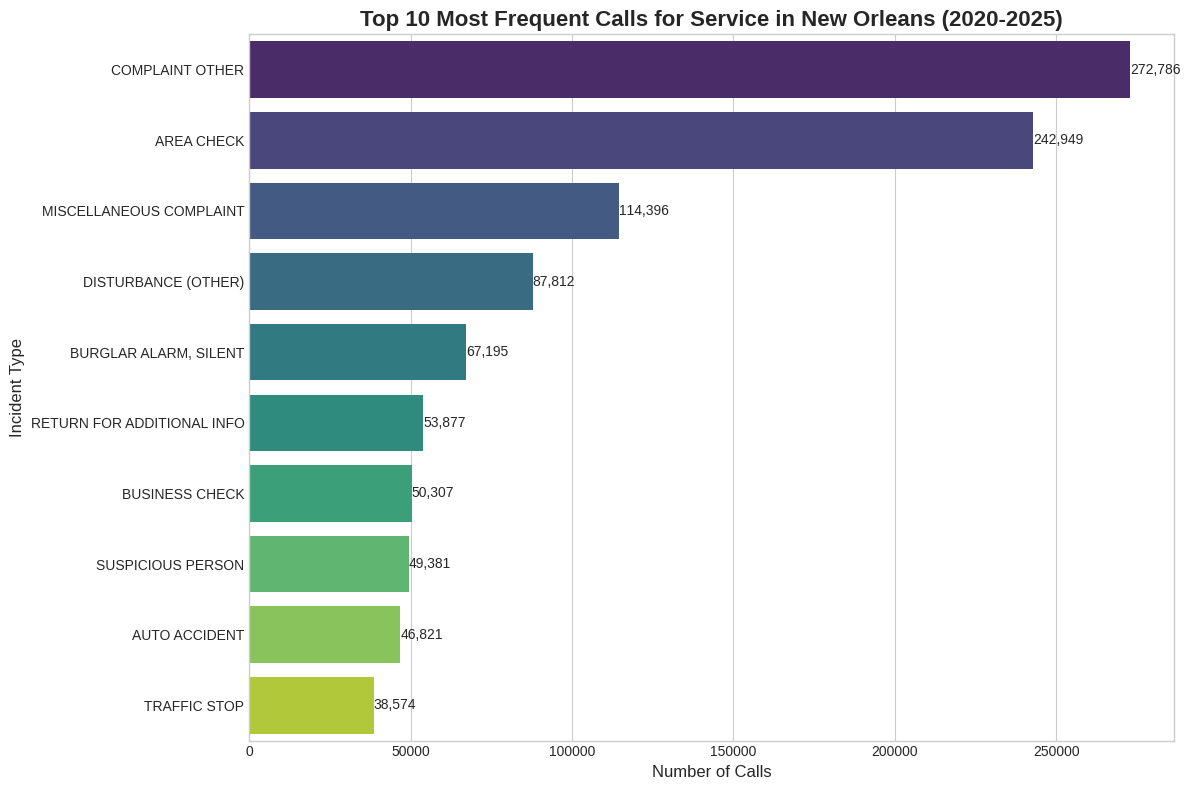

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
cleaned_file_name = 'NOLA_Calls_for_Service_Cleaned.csv'
output_chart_file = 'NOLA_Top_10_Incidents.png'
# -------------------

print(f"Loading cleaned data from '{cleaned_file_name}'...")
df = pd.read_csv(cleaned_file_name, low_memory=False)

# --- Analysis ---
# Using the correct column name 'typetext' for the analysis.
incident_counts = df['typetext'].value_counts()
top_10_incidents = incident_counts.head(10)

print("\nTop 10 Most Frequent Incident Types:")
print(top_10_incidents)

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x=top_10_incidents.values, y=top_10_incidents.index, palette='viridis', ax=ax)

# --- Formatting for Publication ---
ax.set_title('Top 10 Most Frequent Calls for Service in New Orleans (2020-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Calls', fontsize=12)
ax.set_ylabel('Incident Type', fontsize=12)

# Add data labels to the end of the bars
for i in ax.containers:
    ax.bar_label(i, fmt='{:,.0f}')

plt.tight_layout()

# --- Save the Figure ---
plt.savefig(output_chart_file, dpi=300)
print(f"\nSuccess! Chart saved as '{output_chart_file}'.")
plt.show()

Loading cleaned data from 'NOLA_Calls_for_Service_Cleaned.csv'...

Incident Counts by Hour of Day:
hour_of_day
0     60383
1     55252
2     49095
3     44940
4     42751
5     40721
6     34547
7     51690
8     72242
9     75898
10    78898
11    79344
12    79723
13    76727
14    68945
15    78935
16    85486
17    83346
18    74672
19    72323
20    75035
21    71316
22    60477
23    61560
Name: count, dtype: int64

Success! Chart saved as 'NOLA_Incidents_by_Hour.png'.


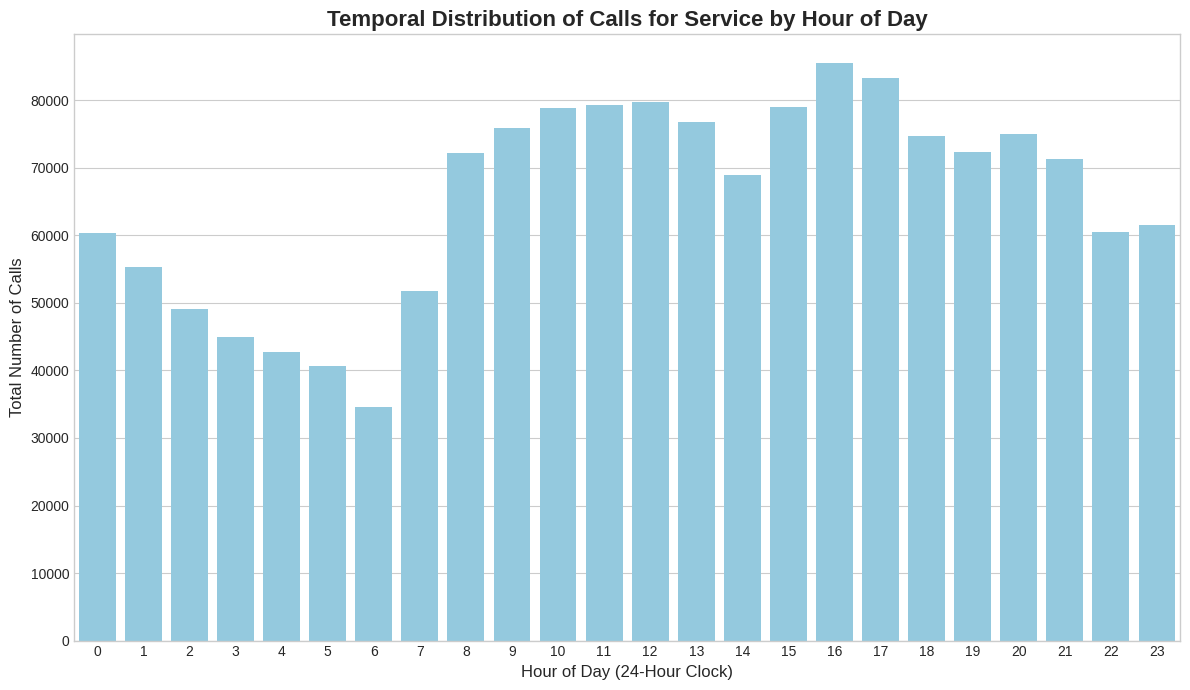

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
cleaned_file_name = 'NOLA_Calls_for_Service_Cleaned.csv'
output_chart_file = 'NOLA_Incidents_by_Hour.png'
# -------------------

print(f"Loading cleaned data from '{cleaned_file_name}'...")
df = pd.read_csv(cleaned_file_name)

# --- Analysis ---
# Convert 'timecreate' column to datetime objects if not already done
df['timecreate'] = pd.to_datetime(df['timecreate'], errors='coerce')
df.dropna(subset=['timecreate'], inplace=True) # Drop rows where conversion failed

# Extract the hour of the day (0-23) from the 'timecreate' column
df['hour_of_day'] = df['timecreate'].dt.hour

# Count the number of incidents for each hour
hourly_counts = df['hour_of_day'].value_counts().sort_index()

print("\nIncident Counts by Hour of Day:")
print(hourly_counts)

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Create the bar plot
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='skyblue', ax=ax)

# --- Formatting for Publication ---
ax.set_title('Temporal Distribution of Calls for Service by Hour of Day', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour of Day (24-Hour Clock)', fontsize=12)
ax.set_ylabel('Total Number of Calls', fontsize=12)
ax.set_xticks(range(24)) # Ensure all 24 hours are shown as ticks

plt.tight_layout()

# --- Save the Figure ---
plt.savefig(output_chart_file, dpi=300)

print(f"\nSuccess! Chart saved as '{output_chart_file}'.")
plt.show()

In [ ]:
from google.colab import files
import os

# --- Upload and Unzip ---
# 1. Remove any old, incomplete shapefiles to avoid confusion
if os.path.exists('Orleans_Parish_Tracts.shp'):
    print("Removing old shapefile components...")
    # This loop cleans up any stray .shp, .shx, .dbf files
    for extension in ['shp', 'shx', 'dbf', 'prj', 'cpg', 'xml']:
        if os.path.exists(f'Orleans_Parish_Tracts.{extension}'):
            os.remove(f'Orleans_Parish_Tracts.{extension}')

# 2. Upload the new ZIP file
print("\nPlease upload the 'Orleans_Parish_Tracts.zip' file you just created.")
uploaded = files.upload()
zip_file_name = list(uploaded.keys())[0]

# 3. Unzip the file
os.system(f"unzip -q '{zip_file_name}'")

print(f"\nSuccess! All shapefile components have been uploaded and unzipped.")


Please upload the 'Orleans_Parish_Tracts.zip' file you just created.


Saving Orleans_Parish_Tracts.zip to Orleans_Parish_Tracts (1).zip

Success! All shapefile components have been uploaded and unzipped.


In [ ]:
import pandas as pd

# Load your poverty data file
poverty_file = 'ACSST5Y2023.S1701-Data.csv'
df_poverty = pd.read_csv(poverty_file, header=1) # header=1 skips the top row

# Print all the column names
print("Here are the exact column names in your poverty data file:")
print(list(df_poverty.columns))

Here are the exact column names in your poverty data file:
['Geography', 'Geographic Area Name', 'Estimate!!Total!!Population for whom poverty status is determined', 'Margin of Error!!Total!!Population for whom poverty status is determined', 'Estimate!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years', 'Margin of Error!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years', 'Estimate!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years!!Under 5 years', 'Margin of Error!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years!!Under 5 years', 'Estimate!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years!!5 to 17 years', 'Margin of Error!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years!!5 to 17 years', 'Estimate!!Total!!Population for whom poverty status is determined!!AGE!!Under 18 years!!Related children of householder under 18 years',

In [ ]:
import pandas as pd
import geopandas as gpd

# --- Configuration ---
shapefile = 'Orleans_Parish_Tracts.zip'
poverty_file = 'ACSST5Y2023.S1701-Data.csv'
# -------------------

print("--- DIAGNOSTIC SCRIPT ---")

# --- 1. Inspect the Shapefile Data ---
print("\nLoading Shapefile...")
gdf_tracts = gpd.read_file(shapefile)
# Prepare the TRACTCE column for inspection
gdf_tracts['TRACTCE_clean'] = gdf_tracts['TRACTCE'].astype(str).str.strip()
print("Sample of TRACTCE from the Shapefile Map:")
print(gdf_tracts['TRACTCE_clean'].head().to_list())


# --- 2. Inspect the Poverty Data ---
print("\nLoading Poverty Data...")
df_poverty = pd.read_csv(poverty_file, header=1)
df_poverty_final = pd.DataFrame() # Create an empty dataframe to add to
# Prepare the TRACTCE column for inspection
df_poverty_final['TRACT_NAME'] = df_poverty['Geographic Area Name']
df_poverty_final['TRACTCE_clean'] = df_poverty_final['TRACT_NAME'].str.extract(r'Census Tract (\d+\.?\d*)')[0].str.replace('.', '', regex=False).str.strip()
print("Sample of TRACTCE from the Poverty CSV File:")
print(df_poverty_final['TRACTCE_clean'].head().to_list())


# --- 3. Check Merge Success ---
merged_df = pd.merge(gdf_tracts, df_poverty_final, on='TRACTCE_clean', how='inner')
print(f"\nNumber of tracts successfully merged: {len(merged_df)}")
if len(merged_df) == 0:
    print("--- DIAGNOSIS: The merge is failing. The TRACTCE values above do not match. ---")
else:
     print("--- DIAGNOSIS: The merge is successful! The script below will work. ---")

--- DIAGNOSTIC SCRIPT ---

Loading Shapefile...
Sample of TRACTCE from the Shapefile Map:
['001500', '001700', '950903', '020601', '020102']

Loading Poverty Data...
Sample of TRACTCE from the Poverty CSV File:
['1', '2', '3', '4', '601']

Number of tracts successfully merged: 0
--- DIAGNOSIS: The merge is failing. The TRACTCE values above do not match. ---


Loading datasets...
Performing spatial join...

--- Data Integration Complete: 142 tracts with full data ---
Creating the correlation plot...

--- SUCCESS! ---
Pearson's Correlation Coefficient: 0.0111
Scatter plot saved as 'NOLA_Poverty_Crime_Correlation.png'.


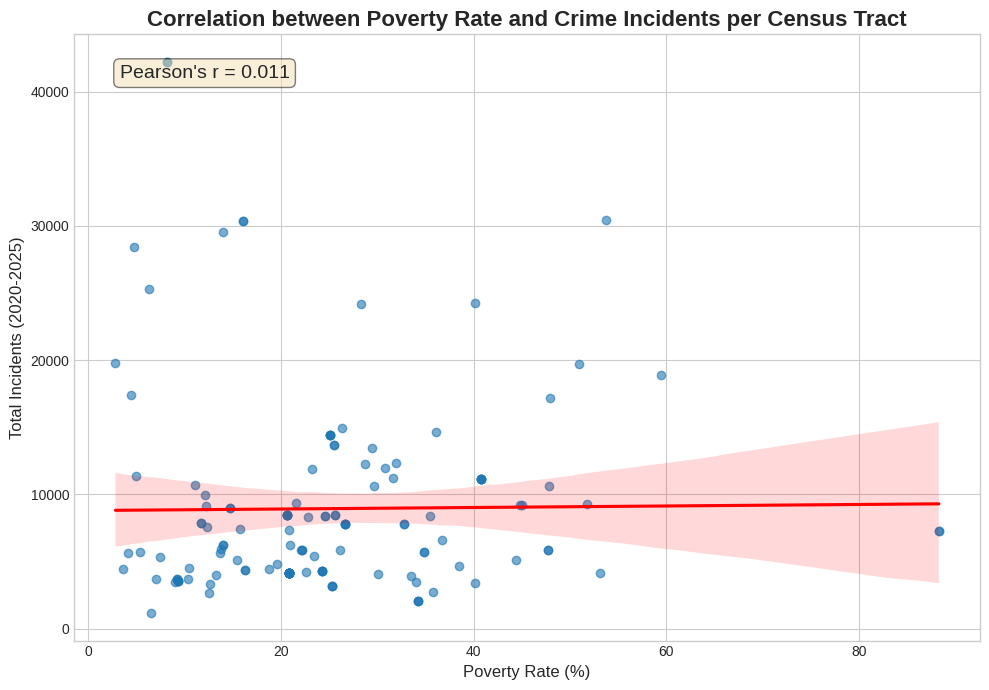

In [ ]:
# First, ensure the necessary libraries are installed
!pip install geopandas matplotlib seaborn

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
crime_file = 'NOLA_Calls_for_Service_Cleaned.csv'
shapefile = 'Orleans_Parish_Tracts.zip'
poverty_file = 'ACSST5Y2023.S1701-Data.csv'
# -------------------


# 1. Load Datasets
print("Loading datasets...")
df_crime = pd.read_csv(crime_file, low_memory=False)
gdf_tracts = gpd.read_file(shapefile)
df_poverty = pd.read_csv(poverty_file, header=1)

# 2. Prepare Poverty Data
col_total_pop = 'Estimate!!Total!!Population for whom poverty status is determined'
col_poverty_pop = 'Estimate!!Below poverty level!!Population for whom poverty status is determined'
df_poverty_subset = df_poverty[['Geographic Area Name', col_total_pop, col_poverty_pop]].copy()
df_poverty_subset[col_total_pop] = pd.to_numeric(df_poverty_subset[col_total_pop], errors='coerce')
df_poverty_subset[col_poverty_pop] = pd.to_numeric(df_poverty_subset[col_poverty_pop], errors='coerce')
df_poverty_subset.dropna(subset=[col_total_pop, col_poverty_pop], inplace=True)
df_poverty_subset = df_poverty_subset[df_poverty_subset[col_total_pop] > 0]
df_poverty_subset['POVERTY_PERCENT'] = (df_poverty_subset[col_poverty_pop] / df_poverty_subset[col_total_pop]) * 100
df_poverty_final = df_poverty_subset[['Geographic Area Name', 'POVERTY_PERCENT']].copy()
df_poverty_final.columns = ['TRACT_NAME', 'POVERTY_PERCENT']
df_poverty_final['TRACTCE'] = df_poverty_final['TRACT_NAME'].str.extract(r'Census Tract (\d+\.?\d*)')[0].str.replace('.', '', regex=False).str.strip()

# 3. Merge Poverty Data with the Map
# --- THE FINAL FIX: Standardize BOTH TRACTCE columns to the same format ---
# This converts the shapefile's '001500' into a simple '1500' to match the poverty data.
gdf_tracts['TRACTCE'] = gdf_tracts['TRACTCE'].astype(int).astype(str)
df_poverty_final['TRACTCE'] = df_poverty_final['TRACTCE'].astype(str)
gdf_tracts = gdf_tracts.merge(df_poverty_final[['TRACTCE', 'POVERTY_PERCENT']], on='TRACTCE')

# 4. Prepare Crime Data
if 'latitude' not in df_crime.columns or 'longitude' not in df_crime.columns:
    df_crime[['longitude', 'latitude']] = df_crime['location'].str.extract(r'POINT \((-\d+\.\d+) (\d+\.\d+)\)').astype(float)
df_crime.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime.longitude, df_crime.latitude), crs="EPSG:4326")

# 5. Spatial Join (Count crimes per tract)
print("Performing spatial join...")
gdf_crime = gdf_crime.to_crs(gdf_tracts.crs)
gdf_merged = gpd.sjoin(gdf_crime, gdf_tracts, how="inner", predicate='within')
crime_counts = gdf_merged['TRACTCE'].value_counts().reset_index()
crime_counts.columns = ['TRACTCE', 'CRIME_COUNT']

# 6. Final Combined Dataset
gdf_final = gdf_tracts.merge(crime_counts, on='TRACTCE')
gdf_final.replace([np.inf, -np.inf], np.nan, inplace=True)
gdf_final.dropna(subset=['POVERTY_PERCENT', 'CRIME_COUNT'], inplace=True)

print(f"\n--- Data Integration Complete: {len(gdf_final)} tracts with full data ---")

# --- Visualization and Statistical Analysis ---
if not gdf_final.empty:
    print("Creating the correlation plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.regplot(data=gdf_final, x='POVERTY_PERCENT', y='CRIME_COUNT', scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ax=ax)
    ax.set_title('Correlation between Poverty Rate and Crime Incidents per Census Tract', fontsize=16, fontweight='bold')
    ax.set_xlabel('Poverty Rate (%)', fontsize=12)
    ax.set_ylabel('Total Incidents (2020-2025)', fontsize=12)
    correlation = gdf_final['POVERTY_PERCENT'].corr(gdf_final['CRIME_COUNT'])
    plt.text(0.05, 0.95, f'Pearson\'s r = {correlation:.3f}', transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()

    # --- Save the Figure ---
    output_figure_file = 'NOLA_Poverty_Crime_Correlation.png'
    plt.savefig(output_figure_file, dpi=300)
    print(f"\n--- SUCCESS! ---")
    print(f"Pearson's Correlation Coefficient: {correlation:.4f}")
    print(f"Scatter plot saved as '{output_figure_file}'.")
    plt.show()
else:
    print("\n--- ERROR: Final dataset is empty after merging. Cannot create plot. ---")

Loading and preparing all datasets...
Engineering features for the predictive model...
Training the Random Forest model...
Calculating SHAP values for model explanation...
Creating and saving the SHAP Summary Plot...


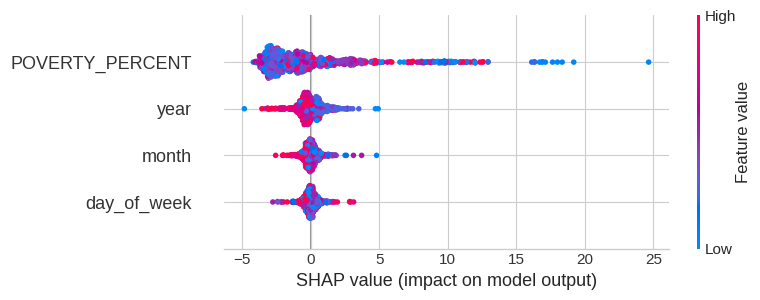


--- SUCCESS! ---
SHAP summary plot saved as 'NOLA_SHAP_Summary.png'.


In [ ]:
# First, ensure the necessary libraries are installed
!pip install geopandas matplotlib seaborn scikit-learn shap

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap

# --- 1. Load and Prepare Data (Combined from previous steps) ---
print("Loading and preparing all datasets...")
crime_file = 'NOLA_Calls_for_Service_Cleaned.csv'
shapefile = 'Orleans_Parish_Tracts.zip'
poverty_file = 'ACSST5Y2023.S1701-Data.csv'
df_crime = pd.read_csv(crime_file, low_memory=False)
df_crime['timecreate'] = pd.to_datetime(df_crime['timecreate'], errors='coerce')
df_crime.dropna(subset=['timecreate'], inplace=True)
if 'latitude' not in df_crime.columns or 'longitude' not in df_crime.columns:
    df_crime[['longitude', 'latitude']] = df_crime['location'].str.extract(r'POINT \((-\d+\.\d+) (\d+\.\d+)\)').astype(float)
df_crime.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime.longitude, df_crime.latitude), crs="EPSG:4326")
gdf_tracts = gpd.read_file(shapefile)
df_poverty = pd.read_csv(poverty_file, header=1)
col_total_pop = 'Estimate!!Total!!Population for whom poverty status is determined'
col_poverty_pop = 'Estimate!!Below poverty level!!Population for whom poverty status is determined'
df_poverty_subset = df_poverty[['Geographic Area Name', col_total_pop, col_poverty_pop]].copy()
df_poverty_subset[col_total_pop] = pd.to_numeric(df_poverty_subset[col_total_pop], errors='coerce')
df_poverty_subset[col_poverty_pop] = pd.to_numeric(df_poverty_subset[col_poverty_pop], errors='coerce')
df_poverty_subset.dropna(subset=[col_total_pop, col_poverty_pop], inplace=True)
df_poverty_subset = df_poverty_subset[df_poverty_subset[col_total_pop] > 0]
df_poverty_subset['POVERTY_PERCENT'] = (df_poverty_subset[col_poverty_pop] / df_poverty_subset[col_total_pop]) * 100
df_poverty_final = df_poverty_subset[['Geographic Area Name', 'POVERTY_PERCENT']].copy()
df_poverty_final.columns = ['TRACT_NAME', 'POVERTY_PERCENT']
df_poverty_final['TRACTCE'] = df_poverty_final['TRACT_NAME'].str.extract(r'Census Tract (\d+\.?\d*)')[0].str.replace('.', '', regex=False).str.strip()
gdf_tracts['TRACTCE'] = gdf_tracts['TRACTCE'].astype(int).astype(str)
df_poverty_final['TRACTCE'] = df_poverty_final['TRACTCE'].astype(str)
gdf_tracts = gdf_tracts.merge(df_poverty_final[['TRACTCE', 'POVERTY_PERCENT']], on='TRACTCE')

# --- 2. Feature Engineering ---
print("Engineering features for the predictive model...")
gdf_crime['date'] = gdf_crime['timecreate'].dt.date
gdf_crime = gdf_crime.to_crs(gdf_tracts.crs)
gdf_merged = gpd.sjoin(gdf_crime, gdf_tracts, how="inner", predicate='within')
model_data = gdf_merged.groupby(['TRACTCE', 'date']).size().reset_index(name='CRIME_COUNT')
model_data = model_data.merge(gdf_tracts[['TRACTCE', 'POVERTY_PERCENT']], on='TRACTCE')
model_data['date'] = pd.to_datetime(model_data['date'])
model_data['day_of_week'] = model_data['date'].dt.dayofweek
model_data['month'] = model_data['date'].dt.month
model_data['year'] = model_data['date'].dt.year

# --- 3. Train the AI Model ---
print("Training the Random Forest model...")
X = model_data[['POVERTY_PERCENT', 'day_of_week', 'month', 'year']]
y = model_data['CRIME_COUNT']
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# --- 4. Calculate SHAP Values and Plot ---
print("Calculating SHAP values for model explanation...")
# Use a smaller sample for SHAP explanation to speed up the process
X_sample = X.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Create the SHAP summary plot
print("Creating and saving the SHAP Summary Plot...")
output_figure_file = 'NOLA_SHAP_Summary.png'
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False)
plt.savefig(output_figure_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n--- SUCCESS! ---")
print(f"SHAP summary plot saved as '{output_figure_file}'.")